# Simple Bayes Generative Model

Fit data to a gaussian model then sample from it.

* $P(Y|X)$ is the probability of being class Y given image X
* $P(X|Y)$ is the generative model which generate image X given Y.
  $$P(X|Y) = \frac{P(Y|X)\ P(X)}{P(Y)}$$

Given the training data, we can fit the data to a gaussian model to build $P(X|Y)$ and then sample from this gaussian model to generate some images. The following block is doing this task for MNIST dataset

Reading in and transforming data...


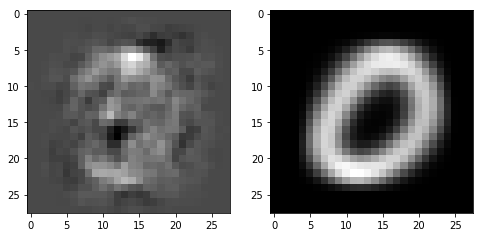

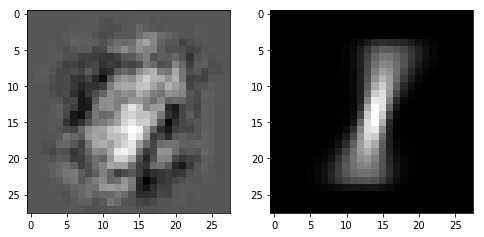

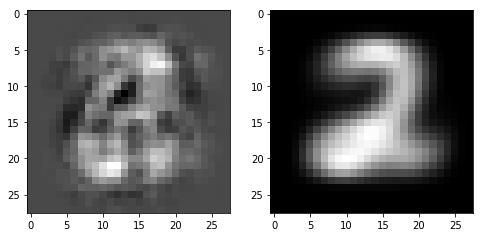

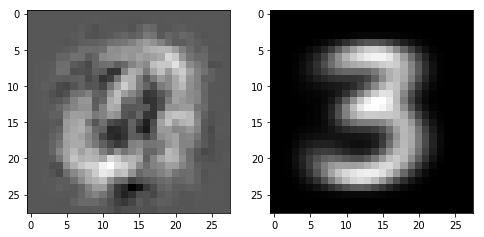

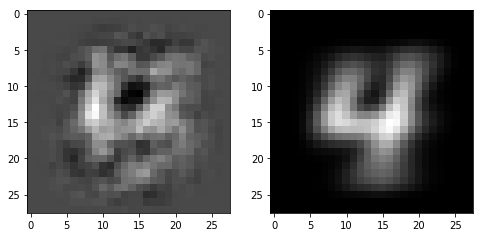

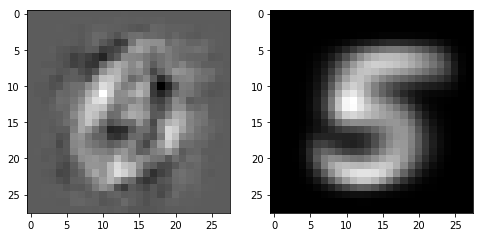

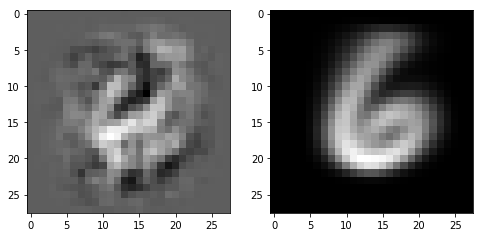

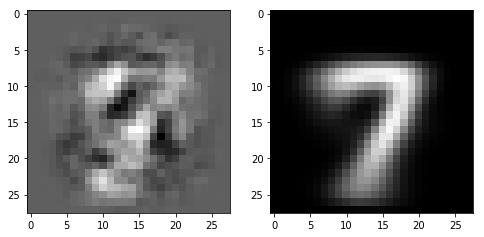

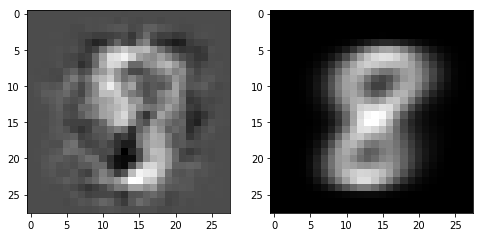

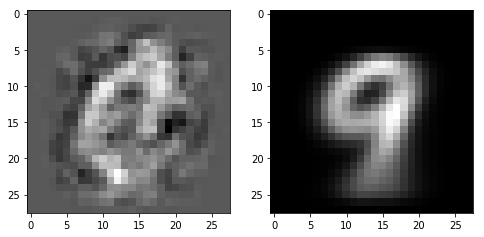

In [14]:
import util
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt


class bayes_generator:
    def fit(self,x,y):
        self.n_cats = len(set(y))
        self.distributions = []
        for cat in range(self.n_cats):
            xK = x[y == cat]
            mean = np.mean(xK,axis = 0)
            cov = np.cov(x.T) # np.cov assumes each row is one variable (here pixel)
            gaussian_dis = {"m":mean, "c": cov}
            self.distributions.append(gaussian_dis)
    
    def sample_give_y(self,cat):
        dist = self.distributions[cat]
        return mvn.rvs(mean = dist["m"],cov=dist["c"])
    

X, Y = util.get_mnist()
gen = bayes_generator()
gen.fit(X,Y)
n_samples = 10
for k in range(n_samples):
    sample_generated = gen.sample_give_y(k).reshape(28,28)
    mean = gen.distributions[k]["m"].reshape(28, 28)
    plt.figure(figsize=(8,16))
    plt.subplot(121)
    plt.imshow(sample_generated,cmap='gray')
    plt.subplot(122)
    plt.imshow(mean,cmap='gray')
    plt.show()

# Using Multimodal Bayes

Without Multimodal, the model cannot for example model the translation and rotation inside image.

How to model it:
* Using [GMM](https://youtu.be/Rkl30Fr2S38) (Gaussian Mixture Model) from scikit learn
* GMM fit miltiple Gaussians with different weigths to the data
* GMM is latent variable model
* Laten variable $z$ represents which cluster $x$ blongs to
* i.e. 2 Clusters: $p(x) = p(z=1)p(x|z=1)+p(z=2)p(x|z=2)$
* $p(z)$ priority that any x belongs ot a cluster $z$
* $p(z)$ is categorical/discrete distribution (vector of numbers that sums to 1)
* $p(x|z)$ is single gaussian


how to assign the cluster:
* Use Bayes Rule!
* $P(z|x) = P(x|z)P(z)/P(x)$

* GMM is trained via expectation-maximization (EM)
* EM is iterative
* You need to choose number of clusters -> solution: VI-GMM

Graphical Model

GMM:
* y --------> z ---------> x
* sample $y\sim p(y)$ (class frequency)
* sample $z\sim p(z|y)$ (Wrting Style)
* sample $x\sim p(x|z,y)$ (image)

Reading in and transforming data...


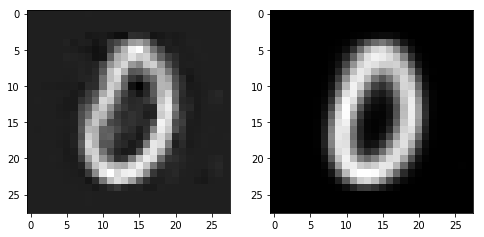

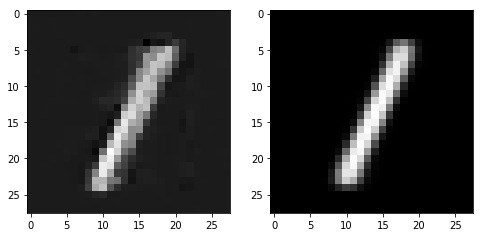

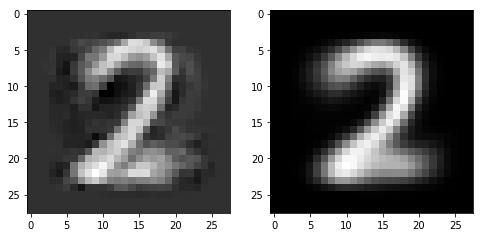

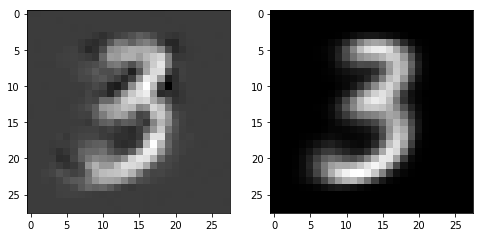

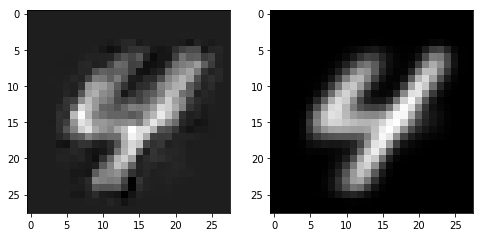

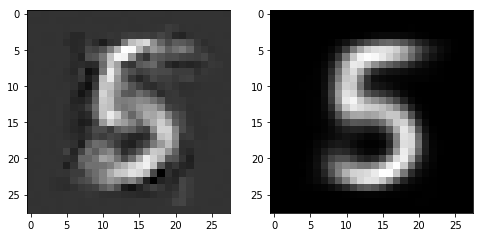

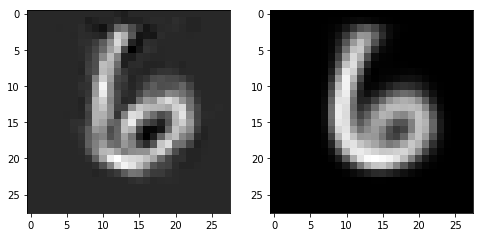

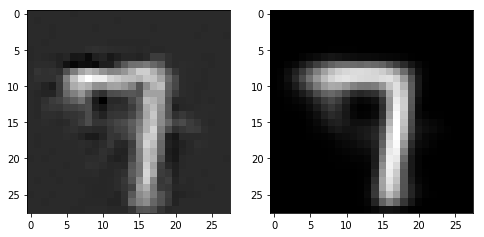

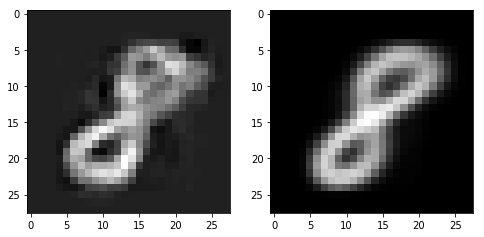

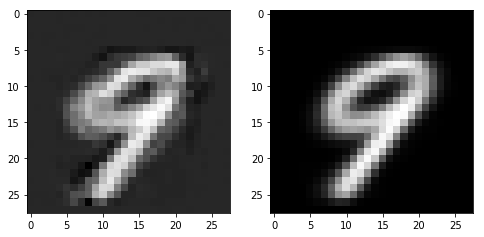

In [21]:
# this block is a lot slower than the previous block.
# but results are much better than the previous.
from sklearn.mixture import BayesianGaussianMixture as bgm

class gmm_gen:
    def __init__(self):
        self.distributions = []
        
    def fit(self,x,y,num):
        self.n_cats = len(set(y))
        self.distributions = []
        for cat in range(self.n_cats):
            xK = x[y == cat]
            gmm = bgm(num)
            gmm.fit(xK)
            self.distributions.append(gmm)
    
    def sample_give_y(self,cat):
        dist = self.distributions[cat]
        sample, cluster = dist.sample()
        meanOfCluster = dist.means_[cluster]
        return sample.reshape(28,28), meanOfCluster.reshape(28,28)

num_styles = 10
X, Y = util.get_mnist()
gen = gmm_gen()
gen.fit(X,Y,num_styles)
n_samples = 10
for k in range(n_samples):
    sample_generated, cluster_mean = gen.sample_give_y(k)
    plt.figure(figsize=(8,16))
    plt.subplot(121)
    plt.imshow(sample_generated,cmap='gray')
    plt.subplot(122)
    plt.imshow(cluster_mean,cmap='gray')
    plt.show()

# Autoencoders
* One of the simplest unsupervised learning
* auto = self
* NN that predicts (construct) its own input
* `fit(X,X)`instead of `fit(X,Y)`
* Hidden Layers to capture important informations/features
* Forces NN to learn compact/efficient representation of the input if num elements in hidden layer are smaller than input size
* Or encodes the data into another format

In [1]:
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import util
import numpy as np

X, Y = util.get_mnist()

Reading in and transforming data...


epoch: 0 batch: 0 cost: 0.23184768855571747
epoch: 0 batch: 100 cost: 0.23016473650932312
epoch: 1 batch: 0 cost: 0.07657001167535782
epoch: 1 batch: 100 cost: 0.037822917103767395
epoch: 2 batch: 0 cost: 0.031441204249858856
epoch: 2 batch: 100 cost: 0.02108239196240902
epoch: 3 batch: 0 cost: 0.02378496155142784
epoch: 3 batch: 100 cost: 0.018203070387244225
epoch: 4 batch: 0 cost: 0.017340051010251045
epoch: 4 batch: 100 cost: 0.014629916287958622
epoch: 5 batch: 0 cost: 0.015586987137794495
epoch: 5 batch: 100 cost: 0.013313827104866505
epoch: 6 batch: 0 cost: 0.014520090073347092
epoch: 6 batch: 100 cost: 0.01332758367061615
epoch: 7 batch: 0 cost: 0.0153776491060853
epoch: 7 batch: 100 cost: 0.01266736164689064
epoch: 8 batch: 0 cost: 0.014642655849456787
epoch: 8 batch: 100 cost: 0.011872168630361557
epoch: 9 batch: 0 cost: 0.013141174800693989
epoch: 9 batch: 100 cost: 0.013074422255158424
epoch: 10 batch: 0 cost: 0.012645592913031578
epoch: 10 batch: 100 cost: 0.01152767613530

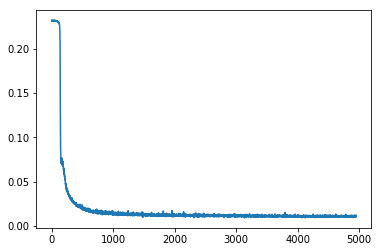

In [18]:
class Autoencoder:
    def __init__(self,input_size, hidden_size):
        tf.reset_default_graph()
        self.x  = tf.placeholder(dtype=tf.float32,shape = (None, input_size))
        init_mean = 0.0
        init_std = 0.001
        self.hidden = tf.layers.dense(self.x,
                                      hidden_size,
                                      activation=tf.nn.relu,
                                      kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                      stddev=init_std),
                                      name = "hiddenLayer")
        self.output = tf.layers.dense(self.hidden,
                                      input_size,
                                      activation=tf.nn.sigmoid,
                                      kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                      stddev=init_std),
                                      name = "outputLayer")
        self.cost = tf.losses.mean_squared_error(self.x,self.output)
        self.train = tf.train.RMSPropOptimizer(learning_rate=0.005).minimize(self.cost)
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
    
    def fit(self, X, epochs=30, batch_sz=64):
        costs = []
        for epoch in range(epochs):
            X = shuffle(X)
            training_size = X.shape[0]
            batch_id = 0
            for batch_start in range(0,training_size, batch_sz):
                batch_end = min(batch_start+batch_sz, training_size-1)
                x_batch = X[batch_start:batch_end,:]
                _,c = self.sess.run([self.train,self.cost],
                                    feed_dict = {self.x:x_batch})
                costs.append(c)
                if (batch_id % 100 == 0):
                    print("epoch: {} batch: {} cost: {}".format(epoch,batch_id,c))
                batch_id +=1
        plt.plot(costs)
        plt.show()
        
    def predict(self,x_in):
        return self.sess.run([self.output,self.hidden],feed_dict = {self.x:x_in})

hidden_side = 6
model = Autoencoder(28*28, hidden_side*hidden_side)
model.fit(X,epochs=30,batch_sz=256)

(28, 28)


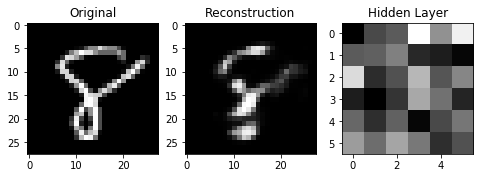

(28, 28)


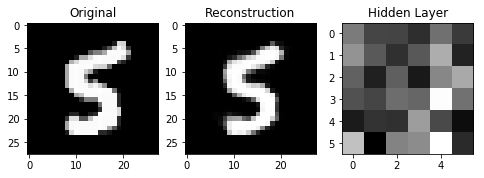

(28, 28)


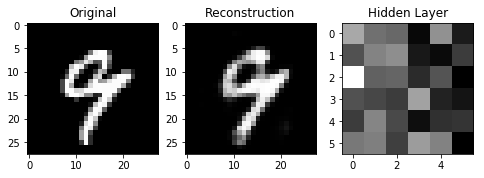

(28, 28)


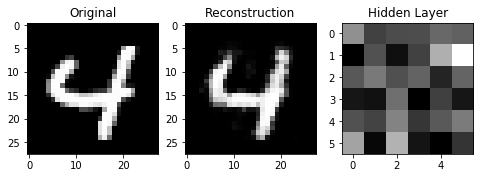

(28, 28)


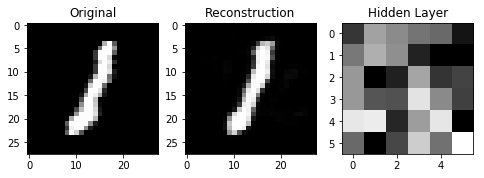

(28, 28)


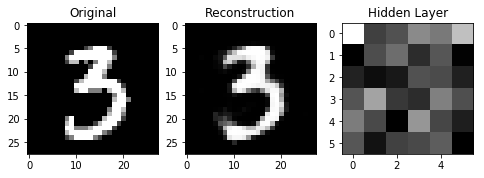

(28, 28)


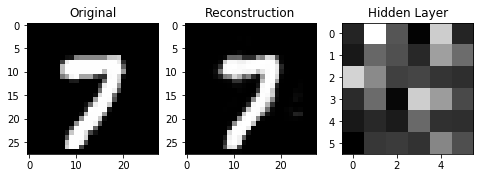

(28, 28)


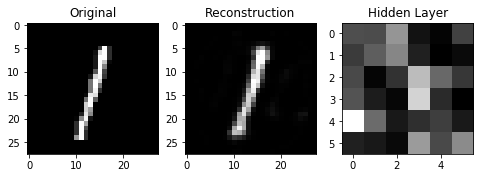

(28, 28)


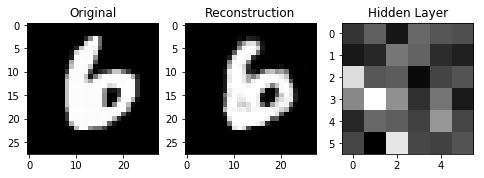

(28, 28)


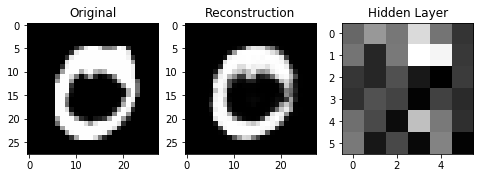

In [19]:
# plot reconstruction
for it in range(10):
    plt.figure(figsize=(8,16))
    i = np.random.choice(len(X))
    x = X[i]
    im,hid = model.predict([x])
    im = np.float32(im.reshape(28, 28))
    print(im.shape)
    hid = np.float32(hid.reshape(hidden_side,hidden_side))
    plt.subplot(131)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(132)
    plt.imshow(im, cmap='gray')
    plt.title("Reconstruction")
    plt.subplot(133)
    plt.imshow(hid, cmap='gray')
    plt.title("Hidden Layer")
    plt.show()

In [20]:
model.sess.close()

# Variational Autoencoder (VAE):
* NN to reproduce its input
* can map data to latent space
* can generate samples by first sampling from latent space

We have seen Autoencoders above. Lets discuss the term Varitational.
* Refers to variational inference/Bayes
* Realm of Bayesian Machine Learning
* Can be thought as an extension of Expectation-maximization (EM)

Data Flow:
* VAE is built by encode and decoder parts.
* Encoder: generates $q(z)$ which is not a value but a distribution or precisely parameters of a distribution.
* In decoder we draw a sample from $z \sim q(z)$ and feed it to the decoder.
* Output of the decodes $\hat{X}$ is also a distribution
* Sometimmes we pick the output as output rather than probability distribution
* $x_{reconstructed} \sim \hat{X}$ we need to generate samples from this distribution
* $p(x_{reconstructed}=1|x)$ in case output is Bernoulli

More Details about Encoder:
* The decoder can output some means and stds.
* std should be positive
    * We can use softplus activation function $softplus(a)=log(1+exp(a))$


* Encoder output distribution is a function of the input $x$  whic is $q(z|x)$
* Encoder is trying to approximate $p(z|x)$.
* $p(z|x)$ can be thought as true conditional distribution of $z|x$, and $q(z|x)$ as our NN approximation of it

# Cost Function:
* Objective Function to increase: ELBO (Evidence Lower Bound):
$$ELBO = E[log\ p(x|z)] - D_{KL}[q(z|x) || p(z)]$$
* Cost is $-ELBO$
* $E[log\ p(x|z)]$ is negative cross-entropy between original data and reconstructed data
* KL-Divergence:
    * KL Divergence between $q(z|x)$ and $p(z)$
    * In Bayesian ML we call $p(z)$ the "prior" and we can choose it.
    * For convenience, we choose $p(z)=N(0,1)$
    * KL divergance allows us to compare two probability distributions
    $$ D_{KL}[q(x) || p(x)] = \int q(x)\ log \frac{q(x)}{p(x)} dx $$
    * if $p=q$, $KDL = 0$
    * if $q!=p$, $KDL >  0$
    * This encourages $q(z|x)$ to be like $p(z)=N(0,1)$
* First Part $E[log\ p(x|z)]$ how close is the output to the target.
* Second part is a regulizer


# The Reparameterization Trick
* We cannot do backward propagation through a function that has sampling
* Encoder outputs mean and std $\mu(x;\theta), \sigma(x;\theta)$
* which represetns $q(z|x)=N(\mu(x;\theta),\sigma(x;\theta)), z \sim q(z|x)$
* $z = \mu(x;\theta) + \sigma(x;\theta) \epsilon, \epsilon \sim N(0,1)$
* Now $\epsilon$ is stochastic and it does not depends on $\theta$
$$ \frac{\partial J}{\partial \theta} = \frac{\partial J}{ \partial z} \frac{\partial z}{\partial \theta} = \frac{\partial J}{\partial z} \Big[\frac{\partial \mu}{\partial \theta} + \epsilon \frac{\partial \sigma}{\partial \theta}\Big]$$

In [1]:
# tesnorflow of VAE
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import util
import numpy as np

X, Y = util.get_mnist()


Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli
logFolder = "../../TFlog"
X = (X > 0.5).astype(np.float32)

Reading in and transforming data...


In [10]:
class VAE:
    def __init__(self, in_size,hidden_layer_sizes,latent_space_size):
        tf.reset_default_graph()
        self.X = tf.placeholder(dtype=tf.float32,shape=(None, in_size))
        init_mean = 0
        init_std = 0.001
        
        num_hidden_layers = len(hidden_layer_sizes)
        self.encoders = []
        self.decoders = []
        
        # encoder Part
        with tf.variable_scope("encoder"):
            input_layer = self.X
            i = 0
            for hidden_size in hidden_layer_sizes:
                i+=1
                input_layer = tf.layers.dense(input_layer,hidden_size,
                                              activation=tf.nn.relu,
                                              kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                              stddev=init_std),
                                              name = "encoder_" + str(i))
                self.encoders.append(input_layer)
        
        # last layer of encoder: output mean with no activation and std with softmax activation
        self.latent_space_mean = tf.layers.dense(input_layer,
                                                 latent_space_size,
                                                 kernel_initializer=
                                                 tf.random_normal_initializer(mean=init_mean,
                                                                              stddev=init_std),
                                                 name = "latent_mean")
        self.latent_space_std = tf.layers.dense(input_layer,latent_space_size,
                                                activation=tf.nn.softplus,
                                                kernel_initializer=
                                                tf.random_normal_initializer(mean=init_mean,
                                                                             stddev=init_std),
                                                name = "latent_std")

        self.encoders.append(self.latent_space_mean)
        self.encoders.append(self.latent_space_std)
        
        standard_normal = Normal(loc=np.zeros(latent_space_size, dtype=np.float32),
                                 scale=np.ones(latent_space_size, dtype=np.float32))
        
        
        e = standard_normal.sample(tf.shape(self.latent_space_mean)[0])
        self.Z = self.latent_space_mean + self.latent_space_std * e
        
        decoder_in = self.Z
        
        with tf.variable_scope("decoder"):
#             print("----------decoder-----------")
            i = num_hidden_layers
            for hidden_size in reversed(hidden_layer_sizes):
#                 print("decoder", i , hidden_size)
                decoder_in = tf.layers.dense(decoder_in,hidden_size,
                                             activation=tf.nn.relu,
                                             kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                             stddev=init_std),
                                             name = "decoder_"+str(i))
                i-=1
                self.decoders.append(decoder_in)
            logits =tf.layers.dense(decoder_in,in_size,
                                    kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                    stddev=init_std),
                                    name="decoder_last")
        posterior_predictive_logits = logits # save for later
        self.X_hat_distribution = Bernoulli(logits=logits)
        
        # take samples from X_hat
        # we will call this the posterior predictive sample
        self.posterior_predictive = self.X_hat_distribution.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(logits)
        
        # Prior Distribution Sampling
        # take sample from a Z ~ N(0, 1)
        # and put it through the decoder
        # we will call this the prior predictive sample
        
        standard_normal = Normal(
            loc=np.zeros(latent_space_size, dtype=np.float32),
            scale=np.ones(latent_space_size, dtype=np.float32))
        
        Z_std = standard_normal.sample(1)
        current_layer_value = Z_std
        # pass the sample through the decoder
        with tf.variable_scope("decoder",reuse=True):
#             print("----------decoder reuse-----------")
            i = num_hidden_layers
            for hidden_size in reversed(hidden_layer_sizes):
#                 print("decoder", i , hidden_size)
                current_layer_value = tf.layers.dense(current_layer_value,
                                                      hidden_size,
                                                      activation=tf.nn.relu,
                                                      kernel_initializer=
                                                      tf.random_normal_initializer(mean=init_mean,
                                                                                   stddev=init_std),
                                                      name="decoder_"+str(i))
                i-=1
            logits = tf.layers.dense(current_layer_value,
                                     in_size,
                                     name="decoder_last")
        # Bernouli(logits)
        prior_predictive_dist = Bernoulli(logits)
        self.prior_predictive = prior_predictive_dist.sample()
        #probability of each pixel (not relative to each other)
        self.prior_predictive_probs = tf.nn.sigmoid(logits) 
        
        # prior predictive from input
        self.Z_input = tf.placeholder(tf.float32, shape=(None, latent_space_size))
        current_layer_value = self.Z_input
        with tf.variable_scope("decoder",reuse=True):
            i = num_hidden_layers
            for hidden_size in reversed(hidden_layer_sizes):
                current_layer_value = tf.layers.dense(current_layer_value,
                                                      hidden_size,
                                                      activation=tf.nn.relu,
                                                      kernel_initializer=
                                                      tf.random_normal_initializer(mean=init_mean,
                                                                                   stddev=init_std),
                                                      name="decoder_"+str(i),
                                                      reuse=True)
                i-=1
            logits = tf.layers.dense(current_layer_value,
                                     in_size,
                                     name="decoder_last",
                                     reuse=True)
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits)
        
        # optimizer and loss function
        kl = -tf.log(self.latent_space_std) + 0.5 * (self.latent_space_std**2  + self.latent_space_mean**2)-0.5
        kl = tf.reduce_sum(kl, axis=1)
        expected_log_likelihood = tf.reduce_sum(
            self.X_hat_distribution.log_prob(self.X),1)
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)
        
        writer = tf.summary.FileWriter(logFolder, tf.get_default_graph())
        
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
        
    def fit(self,X,epochs = 30, batch_sz=64):
        costs = []
        c = 0
        n_batches = len(X) // batch_sz
        print("n_batches:", n_batches)
        for i in range(epochs):
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j+1)*batch_sz]
                _, c, = self.sess.run((self.train_op, self.elbo), feed_dict={self.X: batch})
                c /= batch_sz # just debugging
                costs.append(c)
            print("Epoch: %d, cost: %.3f" % (i, c),end="\r")
        plt.plot(costs)
        plt.show()
    
    def transform(self, X):
        return self.sess.run(self.latent_space_mean,feed_dict={self.X: X}) 
    
    def prior_predictive_with_input(self, Z):
        return self.sess.run(self.prior_predictive_from_input_probs,feed_dict={self.Z_input: Z})
    
    def posterior_predictive_sample(self, X):
        # returns a sample from p(x_new | X)
        return self.sess.run(self.posterior_predictive, feed_dict={self.X: X})
    
    def prior_predictive_sample_with_probs(self):
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        return self.sess.run((self.prior_predictive, self.prior_predictive_probs))

In [ ]:
vae = VAE(784, [200, 150],100)

n_batches: 164


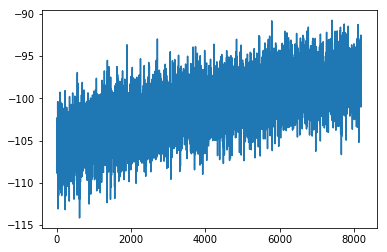

In [4]:
vae.fit(X,batch_sz=256,epochs=50)

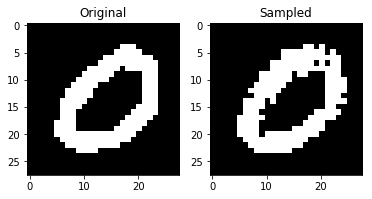

Generate another?


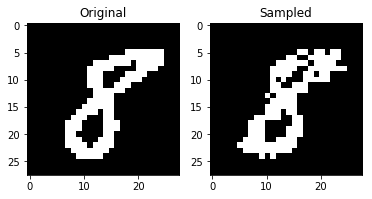

Generate another?


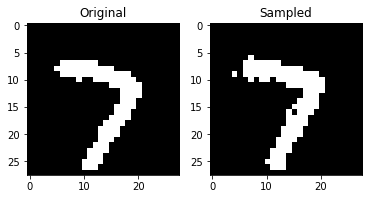

Generate another?


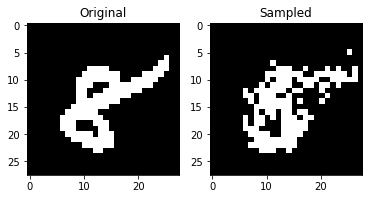

Generate another?


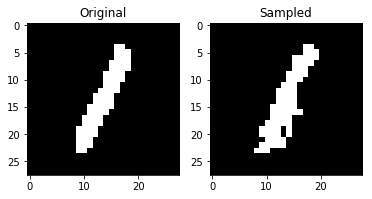

Generate another?


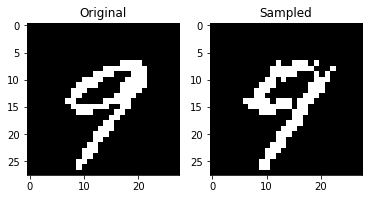

Generate another?


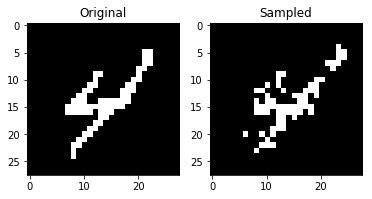

Generate another?n


In [5]:
# plot reconstruction
done = False
while not done:
    i = np.random.choice(len(X))
    x = X[i]
    im = vae.posterior_predictive_sample([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Sampled")
    plt.show()

    ans = input("Generate another?")
    if ans and ans[0] in ('n' or 'N'):
        done = True

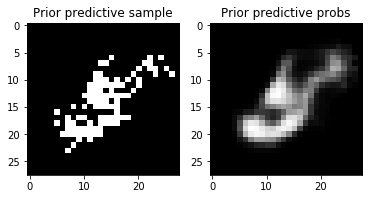

Generate another?


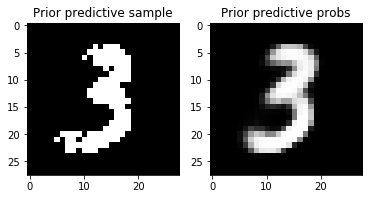

Generate another?


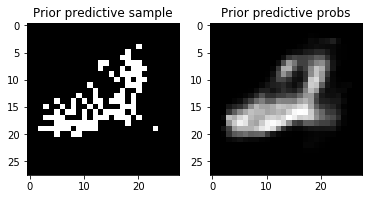

Generate another?


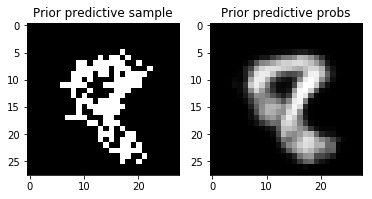

Generate another?


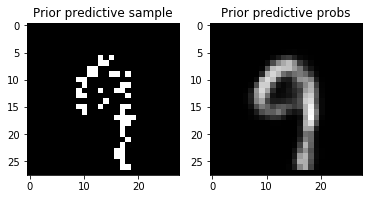

Generate another?


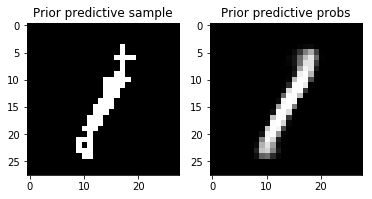

Generate another?


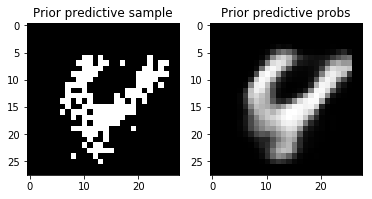

Generate another?


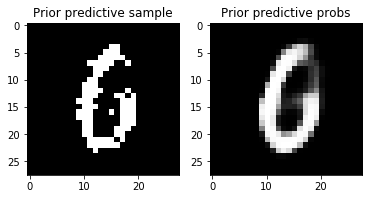

Generate another?


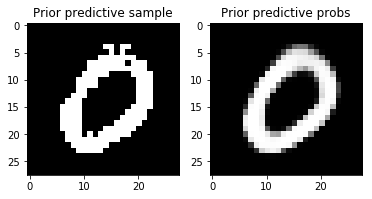

Generate another?


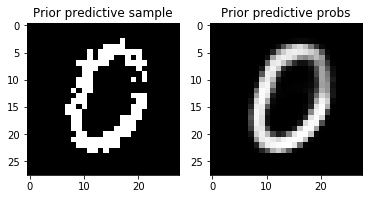

Generate another?n


In [6]:
# plot output from random samples in latent space
done = False
while not done:
    im, probs = vae.prior_predictive_sample_with_probs()
    im = im.reshape(28, 28)
    probs = probs.reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(im, cmap='gray')
    plt.title("Prior predictive sample")
    plt.subplot(1,2,2)
    plt.imshow(probs, cmap='gray')
    plt.title("Prior predictive probs")
    plt.show()

    ans = input("Generate another?")
    if ans and ans[0] in ('n' or 'N'):
        done = True

In [7]:
vae.sess.close()

# Visualize the latent space

n_batches: 164


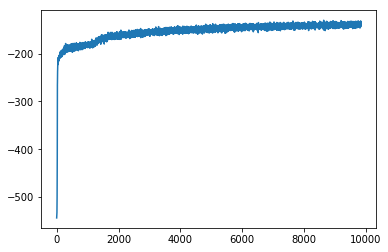

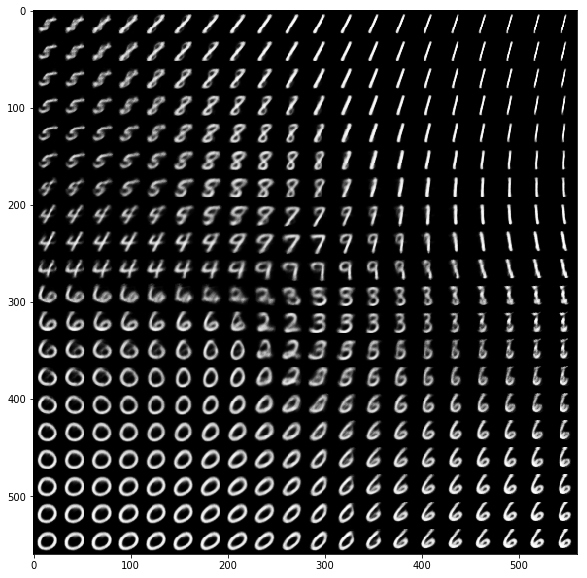

In [11]:
vae = VAE(784, [200, 150],2)
vae.fit(X,batch_sz=256,epochs=60)

n = 20
x_values = np.linspace(-3, 3, n)
y_values = np.linspace(-3, 3, n)
image = np.empty((28 * n, 28 * n))

Z2 = []
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        z = [x, y]
        Z2.append(z)
X_recon = vae.prior_predictive_with_input(Z2)

k = 0
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        x_recon = X_recon[k]
        k += 1
        x_recon = x_recon.reshape(28, 28)
        image[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = x_recon
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.show()
vae.sess.close()

# GANs:
* No explicit distributions
* Generates Sample
* Assesing Sample quality is very subjective (No Number how good it is?)

* 2 NN: Discriminator and Generator
* Discriminator $D(x;\theta_D)$:
    * Real/Fake
    * Binary Classification
    * Objective Function: 
    $$ J = -[t\ log(y) + (1-t)\ log (1-y)]$$
    * let $t = 1$ mean "real" and $t = 0$ "fake".
    * then $y = D(x ; \theta_D) = p(\ image\ is\ real\ |\ image\ ) \in (0,1)$
    * we can use $x$ for real images only and $\hat{x}$ for fake images only then we can simplify teh notation of the loss loss function as follow and get rid of $t$:
    $$J = -[log\ D(x) + log (1-D(\hat{x}))]$$
* Generator $G(z;\theta_G)$:
    * Seems reasonble to use $G(z)$ where $z$ represents a latent prior $z \sim p(z)$
    * 2 steps to sample image:
        1. $z \sim p(z)$
        2. $ \hat{x} = g(z) $

* Again about Discriminator:
    * lets state the loss (cross entropy) differently now:
    $$J^{(D)} = -[log\ D(x) + log (\ 1-\ D(G(z)\ )\ )]$$
    * In case of using batches of images:
    $$ J^{(D)} = - \bigg\{\sum_x log\ D(x) + \sum_z log (\ 1-\ D(G(z)\ )\ ) \bigg\}$$
    * This is really an estimate of the expected value over all possible data?
    $$ J^{(D)} = - \bigg\{E\big[ log\ D(x)] + E [log (\ 1-\ D(G(z)\ )\ ) \big]\bigg\}$$

* 2 Optimization for G and D:
    * We can use:
        $$J^{(G)} = - J^{(D)}$$
    * In game theory, it is called zero-sum Game because sume of all players' costs is always zero

Pseudocode:
0. $X$ =  get batch of real images
0. $\hat{X} =$ sample batch of fake images from $G$
0. update $\theta_D$ by bakprop of $J^{(D)}$
0. update $\theta_G$ by bakprop of $J^{(G)}$ 
0. and repeat.

Problems with Cost Function:
* in $ J^{(D)}$, the derivation of $ J^{(D)}$ wrt $\theta_G$ is zero. So only the second term is relavant wrt Generator.
* Lets assume the Discriminator does a good job as classifier. That means $ D(G(z))$ would be very close to zero.
* Gradient would be zero around it and network would not learn.
* In another word, **when the discriminator is very good, the generator has no chance to improve.**

Solution:
* Use different cost function for Generator
* "Flip the target"
* Instead of a tartget 0 for fake images, the generator wants the target to be 1
$$ J^{(G)} = -E\{ log \ D(G(z))\}$$
* The other term is irrelavent because the gradients rwt generative parameters is zero.
* This is no longer the zero-sum game
* This is refered to as **non-saturating heuristic**: 
    * non-saturating means gradient does not fall to zero
    * heuristic means no theoretical reasoning, just solves the numerical issue.

# DCGAN:
* Deep Convolutional GAN
* contains Batch Normalization
* All convolutional Net: conv -> conv -> conv -> out (no pooling and linear)
* Adam Optimizer
* Leaky Relu for Discriminator and normal Relu for Generator "Solves problem of dead Neurons"

DCGAN Architecture:
![title](DCGANS.png)

```python
# for deconv layers
g_layers = [(1024,4,1,tf.nn.relu),(512,2,2,tf.nn.relu),
            (256,2,2,tf.nn.relu),(128,2,2,tf.nn.relu),
            (3,2,2)] # original above image
g_layers = [(1024,4,1,tf.nn.relu),(512,2,2,tf.nn.relu),
            (1,7,3,None)] # For MNIST (last layer is (N,28,28,1))
# to calculate the output of conv2d_transpose
target_tensor_size = (current_tensor_size + (current_tensor_size-1) * (stride-1)) + (kernel_width - 1)


# for conv layers:
d_layers = [(128,2,2,tf.nn.relu),
            (256,2,2,tf.nn.relu),
            (512,2,2,tf.nn.relu),
            (1024,2,2,tf.nn.relu)] # for image above
d_layers = [(512,5,3,tf.nn.relu),
            (1024,2,2,tf.nn.relu)] # for MINST
```

In [1]:
# tensorflow implementation of GANs:
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import util
import numpy as np
import scipy as sp
import sys
import imageio
import warnings
import skimage

X, Y = util.get_mnist()
X =X.reshape((-1,28,28,1))
print(X.shape, Y.shape)
plt.imshow(np.squeeze(X[100,:,:,:]),cmap="gray")


logFolder = "../../TFlog"
generated_IMG_folder = "images/"
len(X)
# print(X[0,:,:,:])
!rm -rf {logFolder}/*
plt.show()

Reading in and transforming data...
(42000, 28, 28, 1) (42000,)


<Figure size 640x480 with 1 Axes>

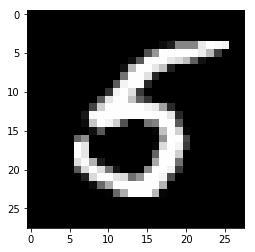

In [8]:
plt.imshow(np.squeeze(X[365,:,:,:]),cmap="gray")
plt.show()

In [2]:
class DCGAN:
    def __init__(self,d_layers,g_layers,image_size):
        """
        d_layers and g_layers should be a list of layers as 
        tuples of (filters, kernel_size,stride,activation_func)
        for example (1024,(3,3),(2,2),tf.nn.relu) for discriminator
        and generator respectively.
        """
        self.image_size = image_size
        self.z_size = 100
        init_std = 0.1
        self.num_iter = 0
        tf.reset_default_graph()
        self.z = tf.placeholder(dtype=tf.float32, shape=(None, self.z_size),name="g_input")
        reshaped_z = tf.reshape(self.z,[-1,1,1, self.z_size],name="reshape")
        gen_cur_layer = reshaped_z
        with tf.variable_scope("Generator"):
            for idx,g_layer in enumerate(g_layers):
                filters, kernel_size,stride,activation_func = g_layer
                gen_cur_layer = tf.layers.conv2d_transpose(gen_cur_layer,filters,kernel_size,stride,
                                                           activation=activation_func,
                                                           kernel_initializer=
                                                           tf.random_normal_initializer(stddev=init_std),
                                                           name="deconv"+str(idx))
        self.g_output = gen_cur_layer
        print("Generator Output Shape:", self.g_output.get_shape())
        self.image_chanels=self.g_output.get_shape()[-1]
        
        self.d_input = tf.placeholder(dtype=tf.float32,
                                      shape=(None,image_size,image_size,self.image_chanels),
                                      name="d_input") 
        num_fake_examples = tf.shape(self.z)[0]
        num_real_examples = tf.shape(self.d_input)[0]
        dis_cur_layer =  tf.concat([self.d_input , self.g_output],axis=0)
        
        with tf.variable_scope("Discriminator"):
            for idx,d_layer in enumerate(d_layers):
                filters, kernel_size,stride,activation_func = d_layer
                dis_cur_layer = tf.layers.conv2d(dis_cur_layer,filters,kernel_size,stride,padding="valid",
                                                 activation=activation_func,
                                                 kernel_initializer=
                                                 tf.random_normal_initializer(stddev=init_std),
                                                 name="conv"+str(idx))
            dis_cur_layer = tf.layers.flatten(dis_cur_layer)
            self.d_output = tf.layers.dense(dis_cur_layer,1,
                                            kernel_initializer=
                                            tf.random_normal_initializer(stddev=init_std),
                                            name="d_output")
        
        #self.label = tf.placeholder(dtype=tf.float32,shape=(None,1),name="FakeReal Label")
        print("Discriminator Output Shape:", self.d_output.get_shape())
        # self.d_output.get_shape()[-1]
        logits_real = tf.slice(self.d_output,[0,0], size=[num_real_examples,1],
                               name = "real_logits")
        logits_fake = tf.slice(self.d_output,[num_real_examples,0],
                               size=[num_fake_examples,1],
                               name = "fake_logits")
        
        # loss functions
        self.d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,
                                                                   labels=tf.ones_like(logits_real))
        self.d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,
                                                                   labels=tf.zeros_like(logits_fake))
        self.d_loss = tf.add(tf.reduce_mean(self.d_loss_real), 
                             tf.reduce_mean(self.d_loss_fake),
                             name="d_loss")
        
        self.g_loss = tf.reduce_mean( 
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,
                                                    labels=tf.ones_like(logits_fake)),name="g_loss")
        real_predictions = tf.cast(logits_real>0,tf.float32)
        fake_predictions = tf.cast(logits_fake<0,tf.float32)
        num_predictions = num_real_examples + num_fake_examples
        num_correct = tf.reduce_sum(real_predictions) + tf.reduce_sum(fake_predictions)
        self.d_accuracy = num_correct / tf.cast(num_predictions,tf.float32)
        
        # get parameters for each network
        self.g_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Generator")
        self.d_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Discriminator")
#         print("d variables" ,self.d_variables)
#         print("g variables" ,self.g_variables)
        
        # train Operations
        self.d_train = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5,
                                              name="d_optimizer").minimize(self.d_loss,
                                                                          var_list=self.d_variables)
        self.g_train = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5,
                                              name="g_optimizer").minimize(self.g_loss,
                                                                          var_list=self.g_variables)
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
        
        self.writer = tf.summary.FileWriter(logFolder,tf.get_default_graph())
        with tf.variable_scope("ForTensorBoard"):
            tile_size = 10
            for i in range(tile_size):
                image_r_tile = tf.reshape(self.g_output[i*tile_size,:,:,:],(image_size,image_size,-1))
                for j in range(1,tile_size):
                    k = j+i*tile_size
                    image_r_tile = tf.concat([image_r_tile,
                                              tf.reshape(self.g_output[k,:,:,:],
                                                         (image_size,image_size,-1))],
                                              axis=1)
                if (i == 0):
                    image_tile = image_r_tile
                else:
                    image_tile = tf.concat([image_tile,
                                            image_r_tile],axis=0)
            self.image_tile = tf.expand_dims(image_tile,axis=0)
            tf.summary.image("Generated_Images",self.image_tile,max_outputs=1)
            tf.summary.scalar("Discriminator_Accuracy",self.d_accuracy)
            tf.summary.scalar("Discriminator_Loss", self.d_loss)
            tf.summary.scalar("Generator_Loss", self.g_loss)
            tf.summary.scalar("d_Loss_real",tf.reduce_mean(self.d_loss_real))
            tf.summary.scalar("d_Loss_fake",tf.reduce_mean(self.d_loss_fake))
            self.summary_merge = tf.summary.merge_all()
    
    def fit(self,X,batch_sz=64,epochs=100,d_cycle=1):
        tf.summary.FileWriterCache.clear()

        d_costs = []
        g_costs = []
        N = len(X)
        dummy_d_input = np.zeros(dtype=np.float32,shape= (1,self.image_size,self.image_size,self.image_chanels))
        state = 0
        
        g_cost2 = 0
        summaries = 0
        d_cost = 0
        d_acc = 0
        for epoch in range(epochs):
            for batch_idx, batch_start in enumerate(range(0,N,batch_sz)):
                self.num_iter +=1
                batch_end = min(N, batch_start+batch_sz)
                batch_X = X[batch_start:batch_end,:,:,:]
                this_batch_len = batch_X.shape[0]
                Z = np.random.uniform(-1.0,1.0,size=(this_batch_len,self.z_size))
                
                if (state%d_cycle == 0) :
                    # train the discriminator
                    _,d_cost,d_acc, = self.sess.run(
                        [self.d_train, self.d_loss,self.d_accuracy],
                        feed_dict={self.d_input: batch_X,self.z:Z})
                    d_costs.append(d_cost)
                    
                    # train the generator twice
                    _,g_cost1 = self.sess.run(
                        [self.g_train, self.g_loss], 
                        feed_dict={self.z:Z, self.d_input:dummy_d_input})
                
                else:
                    # train the generator twice
                    _,g_cost1 = self.sess.run(
                        [self.g_train, self.g_loss], 
                        feed_dict={self.z:Z, self.d_input:dummy_d_input})


                    if (this_batch_len > 100):
                        _,g_cost2,summaries, generated_image = self.sess.run(
                            [self.g_train, self.g_loss,self.summary_merge,self.image_tile], 
                            feed_dict={self.z:Z, self.d_input:dummy_d_input})
                        if num_iter%100 ==0:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore") 
                                generated_image = np.squeeze(generated_image)
                                generated_image = np.interp(generated_image,
                                                            (generated_image.min(),generated_image.max()),
                                                            (0,255))
                                imageio.imwrite(generated_IMG_folder+'samples_at_iter_%d.png' % self.num_iter,
                                                generated_image.astype(np.uint8))#.astype(np.uint8)
                        self.writer.add_summary(summaries,self.num_iter)
                    else:
                        _,g_cost2 = self.sess.run(
                            [self.g_train, self.g_loss], 
                            feed_dict={self.z:Z, self.d_input:dummy_d_input})

                    g_cost = (g_cost1 + g_cost2)/2
                    g_costs.append(g_cost)
                    print("iteration {} epoch {} batch {} d_acc {} d_loss {} g_loss {}       ".format(
                        self.num_iter, epoch, batch_idx,d_acc,d_cost, g_cost),
                          end="\r")
                state += 1

In [3]:
def lrelu(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

g_layers = [(128,4,1,tf.nn.relu),(64,2,2,tf.nn.relu),(1,7,3,tf.nn.sigmoid)]
d_layers = [(32,5,3,lrelu),(64,2,2,lrelu)]
image_size = 28
dcgan = DCGAN(d_layers=d_layers,g_layers=g_layers,image_size=image_size)

Generator Output Shape: (?, 28, 28, 1)
Discriminator Output Shape: (?, 1)


In [4]:
batch_size = 1024
print(len(X)/batch_size)
print(len(X)%batch_size)

41.015625
16


In [5]:
dcgan.fit(X,batch_sz=512,epochs=300,d_cycle=2)

In [9]:
dcgan.sess.close()

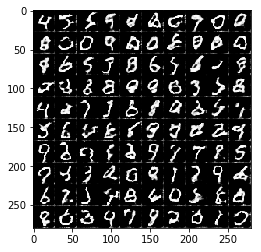

(280, 280, 3)
True


In [12]:
import cv2
import os
import matplotlib.pyplot as plt

jump = 100
imgs_path1 = ["images"+"/samples_at_iter_"+str(i)+".png" for i in range (100,12401, jump)]
#imgs_path2 = ["images02"+"/samples_at_iter_"+str(i)+".png" for i in range (100,12401, jump)]
imgs_path = imgs_path1 #+ imgs_path2
# print (imgs_path)

video_name = 'myvideo.avi'
frame = cv2.imread(imgs_path[-1])
plt.imshow(frame, cmap = 'gray')
plt.show()
height, width, layers = frame.shape
print(frame.shape)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter(video_name, fourcc, 2, (width,height))
for i,image in enumerate(imgs_path):
    if os.path.exists(image):
        frame = cv2.imread(image)
        cv2.putText(frame,"Iteration " + str((i+1)*jump),(0,28),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
        video.write(frame)
video.release()
cv2.destroyAllWindows()
print (os.path.exists(video_name))

In [ ]:
# Explore the tf conv2d transpose:
def upsample(x):
    """
    Apply a two times upsample on x and return the result.
    :x: 4-Rank Tensor
    :return: TF Operation
    """
    # TODO: Use `tf.layers.conv2d_transpose`
    return tf.layers.conv2d_transpose(x, 128, 2, 2)

tf.reset_default_graph()
x = tf.constant(np.random.randn(1,16,16,256), dtype=tf.float32)
conv = upsample(x)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x_res,result = sess.run((x,conv))

    print('Input Shape: {}'.format(x.get_shape()))
    print('Output Shape: {}'.format(result.shape))
#     print (x_res) #.reshape(2,2)
#     print(result.reshape(result.shape[1:3])) #.reshape(4,4)
#     for ten in tf.global_variables():
#         print (ten)
#         print (sess.run(ten).reshape(2,2))#.reshape(2,2)

In [94]:
s = 1
current_tensor_size = 8
target_tensor_size = 28
#target_tensor_size = (current_tensor_size + (current_tensor_size-1) * (s-1)) + (kernel_width - 1)
kernel_width = (target_tensor_size + 1) - (current_tensor_size + (current_tensor_size-1) * (s-1))
kernel_width

21

In [133]:
# Explore the tf conv2d:
def downsample(x):
    """
    Apply a two times upsample on x and return the result.
    :x: 4-Rank Tensor
    :return: TF Operation
    """
    # TODO: Use `tf.layers.conv2d_transpose`
    return tf.layers.conv2d(x, 1, 2, 1,padding="valid",use_bias=False)

tf.reset_default_graph()
x = tf.constant(np.random.randn(1,4,4,1), dtype=tf.float32)
conv = downsample(x)
print ("new print", conv.get_shape())

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x_res,result = sess.run((x,conv))

    print('Input Shape: {}'.format(x.get_shape()))
    print('Output Shape: {}'.format(result.shape))
#     print (x_res.reshape(1,1)) #.reshape(2,2)
#     print(result.reshape(1,1)) #.reshape(4,4)
#     for ten in tf.global_variables():
#         print (ten)
#         print (sess.run(ten).reshape(2,2))#.reshape(2,2)

new print (1, 3, 3, 1)
Input Shape: (1, 4, 4, 1)
Output Shape: (1, 3, 3, 1)


In [132]:
from math import ceil
s = 3
kernel_size = 5
current_tensor_size = 28
target_tensor_size = 8
target_tensor_size = ceil((current_tensor_size - (kernel_size-1))/float(s))
target_tensor_size

8